'''
Here chatBot implemented is basically for taking the user input in the form of .PDF , .txt , .csv format.
Used Hugging Face Sentence transformer , used tiiuae/falcon-7b-instruct which is free in nature.

****PipeLine*****

1.Document Ingestion (Input Layer)
2. Text Preprocessing & Chunking
3. Embedding Generation (Retriever Side)
4. Vector Database
5. Retriever (Search Engine)
6. LLM (Generator Side)
7. Response Delivery (Chat Interface)
'''

In [ ]:
pip install langchain chromadb sentence-transformers transformers pypdf pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.0/368.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 7.4 MB/s

In [ ]:
pip install -U langchain-community


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.0/349.0 kB 18.4 MB/s eta 0:00:00


In [ ]:
pip install -U langchain langchain-community


In [ ]:
# Loading the basic libraries
import os
from langchain.document_loaders import PyPDFLoader, TextLoader, CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

1. Document Ingestion (Input Layer)

The user uploads files (PDF, TXT, CSV).

To extract raw text for further processing.

Tools used:
PyPDFLoader, TextLoader, CSVLoader (LangChain document loaders).

In [ ]:
# 1. Load multiple documents
def load_documents(file_paths):
    all_docs = []
    for file_path in file_paths:
        if file_path.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif file_path.endswith('.txt'):
            loader = TextLoader(file_path)
        elif file_path.endswith('.csv'):
            loader = CSVLoader(file_path)
        else:
            raise ValueError(f"Unsupported file format: {file_path}")

        all_docs.extend(loader.load())
    return all_docs

2. Text Preprocessing & Chunking
What happens?
Large text is split into chunks (e.g., 500–1000 tokens) with some overlap.

Why?
LLMs have context window limits (e.g., 4k tokens). Chunking keeps context relevant and efficient.

Tools used:
RecursiveCharacterTextSplitter (LangChain).

NLP role:
Breaking text at logical points, preserving meaning with overlap.

In [ ]:
# 2. Split documents into chunks
def split_documents(documents, chunk_size=1000, chunk_overlap=200):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    return text_splitter.split_documents(documents)

3. Embedding Generation (Retriever Side)
What happens?
Each chunk → converted into dense vector representation.

How?
Using a Transformer-based encoder model (e.g., sentence-transformers/all-MiniLM-L6-v2).

Why?
To enable semantic search—finding chunks similar to the query.

Tools used:
HuggingFaceEmbeddings (LangChain).

Transformer role:
✔ Encoder-only model (like BERT/MiniLM) is used here.
✔ It uses self-attention to capture semantic meaning of words in context.

In [ ]:
# 3. Create embeddings using HuggingFace
def create_vector_store(docs):
    embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vectorstore = Chroma.from_documents(docs, embedding_model)
    return vectorstore

4. Vector Database
What happens?
Store all embeddings in a vector store for fast similarity search.

Why?
Efficient retrieval using cosine similarity or dot product.

Tools used:
Chroma or FAISS.

NLP role:
None here—this is pure vector storage and retrieval.

In [ ]:
# 4. Setup Free HuggingFace LLM
def get_llm():
    model_name = "tiiuae/falcon-7b-instruct"  # Or "gpt2" for faster testing
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    hf_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        temperature=0.2
    )

    return HuggingFacePipeline(pipeline=hf_pipeline)

5. Retriever (Search Engine)
What happens?
When the user asks a question, convert query → embedding → retrieve top-k most relevant chunks.

Why?
Provide the LLM with grounded context from original documents.

Tools used:
vectorstore.as_retriever() in LangChain.

Transformer role:
Uses the same embedding model to encode the query.

In [ ]:
# 5. Build RAG Pipeline
def build_rag_pipeline(vectorstore):
    llm = get_llm()
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff"
    )
    return qa_chain

6. LLM (Generator Side)
What happens?
The retrieved chunks + user query → passed to the Language Model.

Why?
To generate a natural language response using both context and query.

Tools used:
Hugging Face models (e.g., tiiuae/falcon-7b-instruct) loaded with transformers pipeline.

Transformer role:
✔ Decoder-only Transformer generates the final answer token by token.
✔ Uses self-attention + causal masking for autoregressive generation.

In [ ]:
# 6. Main Chatbot
def rag_chatbot(file_paths):
    print("Loading documents...")
    documents = load_documents(file_paths)

    print("Splitting documents...")
    docs = split_documents(documents)

    print("Creating vector store...")
    vectorstore = create_vector_store(docs)

    print("Building RAG pipeline...")
    qa_chain = build_rag_pipeline(vectorstore)

    print("\nChatbot is ready! Type 'exit' to quit.\n")

    while True:
        query = input("You: ")
        if query.lower() == "exit":
            break
        response = qa_chain.run(query)
        print("Bot:", response)

7. Response Delivery
What happens?
The LLM outputs the answer to the user.

NLP role:
Final text generation and formatting.



In [ ]:
# Run the chatbot
if __name__ == "__main__":
    file_paths = ["/content/sample_data/RAG_Chatbot_Transformer_Complete_Guide.pdf"]  # Add your files here


In [ ]:
rag_chatbot(file_paths)

Loading documents...
Splitting documents...
Creating vector store...


/tmp/ipython-input-490645480.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Building RAG pipeline...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

Device set to use cpu
/tmp/ipython-input-2498918634.py:15: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  return HuggingFacePipeline(pipeline=hf_pipeline)



Chatbot is ready! Type 'exit' to quit.

You: what are tokens


/tmp/ipython-input-1931676148.py:21: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa_chain.run(query)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Bot: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

✔ Mention tokenization and positional encoding as essential for context.
Pro Tip: If asked, draw the Transformer block (attention + feed-forward) and explain its role in
retrieval and generation.

✔ Attention Mechanism: Core concept that lets models focus on important parts of the input
sequence.
✔ Encoder: Used in embedding models (retrieval). Converts chunks into contextual embeddings.
✔ Decoder: Used in LLM (generation). Takes user query + retrieved context and predicts next
tokens.
Key Components:
- Self-Attention: Calculates attention weights between tokens in the same sequence.
- Multi-Head Attention: Captures multiple relationships simultaneously.
- Feed Forward Network: Adds non-linearity for better representation.
- Positional Encoding: Adds order info to sequences.
How Encoder-Decoder Works for RAG:
✔ Retrieve

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Bot: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

✔ Mention tokenization and positional encoding as essential for context.
Pro Tip: If asked, draw the Transformer block (attention + feed-forward) and explain its role in
retrieval and generation.

✔ Attention Mechanism: Core concept that lets models focus on important parts of the input
sequence.
✔ Encoder: Used in embedding models (retrieval). Converts chunks into contextual embeddings.
✔ Decoder: Used in LLM (generation). Takes user query + retrieved context and predicts next
tokens.
Key Components:
- Self-Attention: Calculates attention weights between tokens in the same sequence.
- Multi-Head Attention: Captures multiple relationships simultaneously.
- Feed Forward Network: Adds non-linearity for better representation.
- Positional Encoding: Adds order info to sequences.
How Encoder-Decoder Works for RAG:
✔ Retrieve

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Bot: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

✔ Attention Mechanism: Core concept that lets models focus on important parts of the input
sequence.
✔ Encoder: Used in embedding models (retrieval). Converts chunks into contextual embeddings.
✔ Decoder: Used in LLM (generation). Takes user query + retrieved context and predicts next
tokens.
Key Components:
- Self-Attention: Calculates attention weights between tokens in the same sequence.
- Multi-Head Attention: Captures multiple relationships simultaneously.
- Feed Forward Network: Adds non-linearity for better representation.
- Positional Encoding: Adds order info to sequences.
How Encoder-Decoder Works for RAG:
✔ Retriever uses an Encoder-only Transformer (e.g., BERT) to create embeddings of text
chunks.
✔ Generator uses a Decoder-only Transformer (e.g., GPT) to generate responses.
✔ RAG pipeline:
- User query → en

RAG(Retrieval-Augmented Generation) based Chat Bot Prompt.

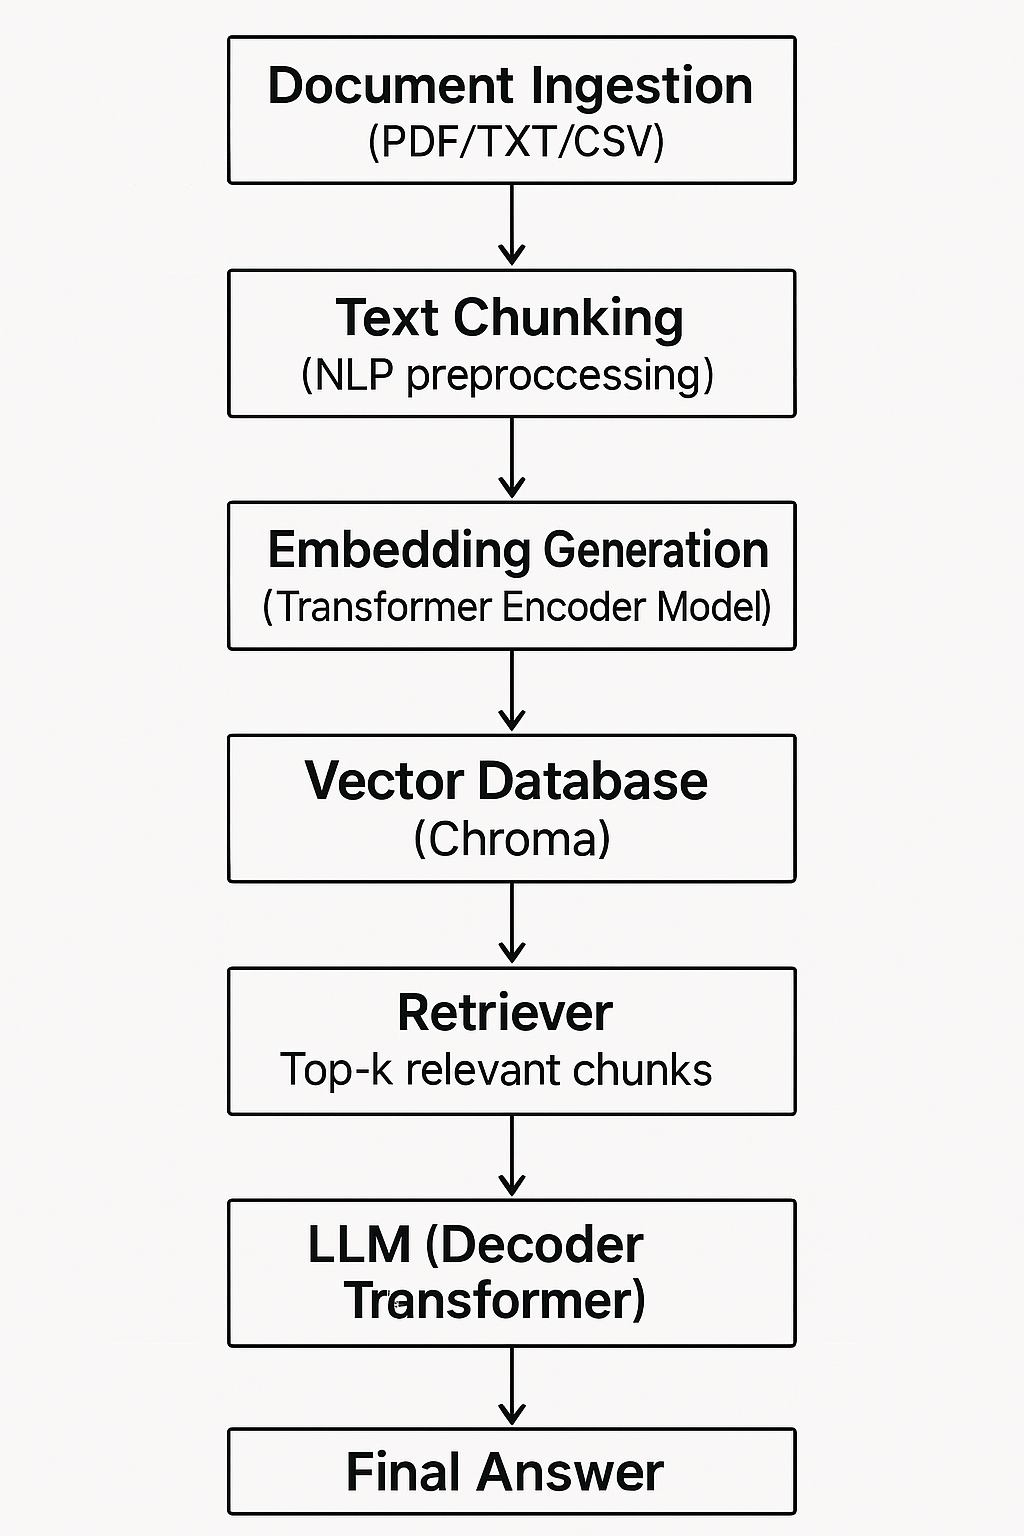